In [20]:
# %% Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,callbacks
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# %% Load Data
df = pd.read_csv('data/car_price_prediction_.csv')
df = df.drop('Car ID', axis=1)


df.shape

(2500, 9)

In [21]:
# %% Preprocessing
# Identify numerical and categorical columns
numerical_cols = ['Year', 'Engine Size', 'Mileage']
categorical_cols = ['Brand', 'Fuel Type', 'Transmission', 'Condition', 'Model']

# Define preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('scaler', MinMaxScaler())  # Normalize
])

# Define preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encoding
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)



In [22]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

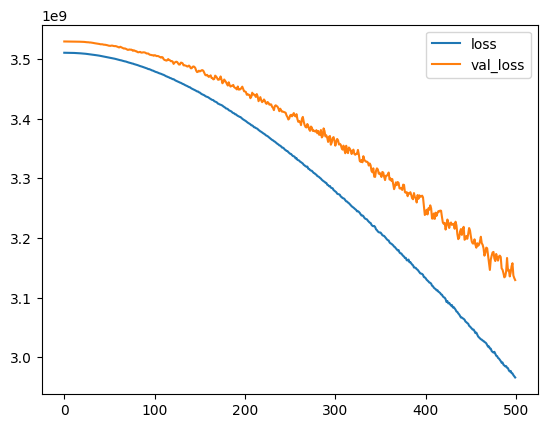

In [23]:
# Define features and target variable
X = df.drop(columns='Price', axis=1)
Y = df['Price']

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

# Preprocess the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)



In [ ]:
# %% Build Neural Network
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # Dropout layer
    layers.BatchNormalization(),  # Batch Normalization
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1)  # Output layer for regression
])




In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log
)



In [ ]:

# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();